In [36]:
import os
import random
import numpy as np
import pandas as pd

import cv2
cv2.ocl.setUseOpenCL(False)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, MinMaxScaler, LabelBinarizer

from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
from matplotlib import transforms

from tqdm import tqdm
import re

import tensorflow as tf

#Si vous n'avez pas de GPU ou que vous ne voulez pas l'utiliser, commentez les 2 lignes suivantes
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing import image    
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras.models import load_model


LE = LabelEncoder()

from PIL import Image

2.4.1


In [2]:
os.environ['TF_DETERMINISTIC_OPS'] = '1' #  c'est la ligne la plus importante
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUDA_VISIBLE_DEVICES'] = '' #  c'est facultatif
os.environ['OPENCV_OPENCL_DEVICE'] = 'disabled'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data_dir = '../data/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [4]:
race_dirs = os.listdir('../data/train')
race_dirs_indexed = LE.fit_transform(race_dirs)
class_names = pd.DataFrame([race_dirs_indexed, race_dirs]).transpose()

In [5]:
def all_images_path(data_type):
    all_images_path = []
    for i in race_dirs:
        folder_path = '../data/' + data_type + '/' + i + '/'
        for u in os.listdir(folder_path):
            all_images_path.append(folder_path + u)
        
    return all_images_path

In [6]:
len(all_images_path('train')) 

16469

In [7]:
len(all_images_path('valid'))

4111

In [8]:
def get_race_from_img_path(img_path):
    full_path_img = os.path.splitext(img_path)[0]
    race = full_path_img.split('/')[3]
    index = class_names[class_names[1] == race].values[0][0]
    return index, race

def display_image(x):
    '''
    function shows images in training set
    INPUT: integer between 0 and 16468
    OUTPUT: image
    '''
    img_path = all_images_path('train')[x]
    img = cv2.imread(img_path)
    index, race = get_race_from_img_path(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    return index, race

In [9]:
index, race = get_race_from_img_path(all_images_path('train')[345])
print("{}: {}".format(index, race))

2: n02085936-Maltese_dog


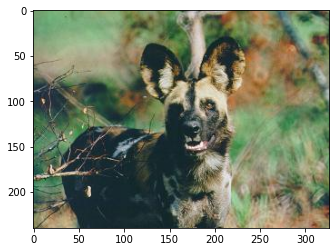

(119, 'n02116738-African_hunting_dog')

In [10]:
display_image(16468)

In [11]:
def load_img(i):
    img = all_images_path('train')[i]
    img = tf.keras.preprocessing.image.load_img(img, target_size=(150, 150))
    return img

#def load_label(i):
    #img_path = all_images_path[i]
    #label_index = train_mat_train_info.labels[i]
    #label_race = class_names[label_index-1]
    
    #return "{} [{}]".format(label_race, label_index)

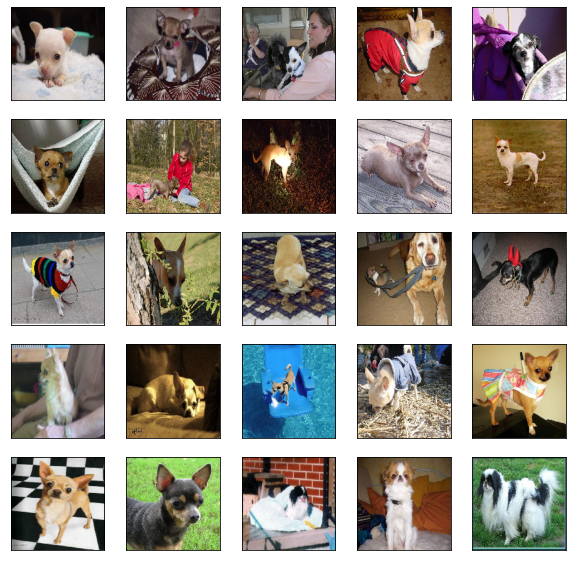

In [12]:
plt.figure(figsize=(10,10))

for i in range(100, 125):
    plt.subplot(5,5,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_img(i))
    
plt.show()

## Preprocessing of the images before training

In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rescale=1./255,rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [14]:
batch_size=20

In [15]:
train_gen = train_datagen.flow_from_directory(
    '../data/train', 
    target_size=(150, 150), 
    batch_size=batch_size, 
    classes=[*race_dirs]
)

Found 16469 images belonging to 120 classes.


In [16]:
val_gen = val_datagen.flow_from_directory(
    '../data/valid', 
    target_size=(150, 150), 
    batch_size=batch_size, 
    classes=[*race_dirs]
)

Found 4111 images belonging to 120 classes.


In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [18]:
imgs, labels = next(val_gen)

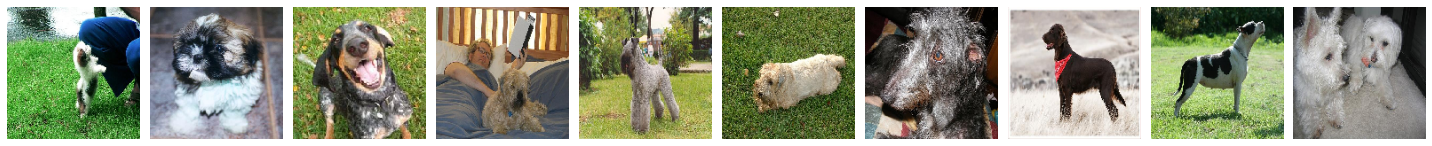

In [19]:
plotImages(imgs)

## Input and Output layers (CNN from scratch)

In [20]:
class_num = len(race_dirs)
print(class_num)

120


In [21]:
inputs = Input(shape=(150, 150, 3))

x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2)(x)

x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
#x = Dropout(0.4)(x)

x = Conv2D(128, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
#x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.4)(x)


outputs = Dense(class_num, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

## Setting model compiler

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], 
              optimizer='rmsprop')

## Training model

In [ ]:
history = model.fit(train_gen, epochs=15, steps_per_epoch=823, 
                   validation_data=val_gen, validation_steps=205)

## Accuracy plotting after training

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, "b", label='accuracy')
plt.plot(epochs, val_acc, "r", label='validation_accuracy')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, "b", label='loss')
plt.plot(epochs, val_loss, "r", label='validation_loss')
plt.title('Training and validation loss')

## Save model

In [ ]:
#model.save('../models/dogs_dataset_big.h5')

In [ ]:
#model.save('../models/dogs_dataset_weird.h5')

In [ ]:
#model.save('../models/dogs_dataset_big_50_batch.h5')

In [ ]:
#model.save('../models/dogs_dataset_big_50_batch_2.h5')

In [ ]:
#model.save('../models/dogs_dataset_big_20_original.h5')

In [ ]:
model.save('../models/model_25.h5')

In [ ]:
#model.save('../models/model_15e_1plus_layer.h5')

## Load model

In [15]:
#model = load_model('../models/dogs_dataset_big.h5')

In [13]:
#model = load_model('../models/dogs_dataset_weird.h5')

In [30]:
#model = load_model('../models/dogs_dataset_big_50_batch.h5')

In [27]:
model = load_model('../models/dogs_dataset_big_50_batch_2.h5')

In [ ]:
#model = load_model('../models/dogs_dataset_big_20_original.h5')

In [25]:
#model = load_model('../models/model_25.h5')

In [23]:
#model = load_model('../models/model_15e_1plus_layer.h5')

In [28]:
model = load_model('../models/VGG16_MODEL.h5')

## Evaluation des models

In [30]:
encoder = LabelBinarizer()

def load_and_preprocess_image(path):
        image = cv2.imread(path)
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

def test_data_for_evaluation(env):
    BASEPATH = "../data/" + env +"/"

    LABELS = set()

    paths = []

    for d in os.listdir(BASEPATH):
        LABELS.add(d)
        paths.append((BASEPATH+d, d))

    X = []
    y = []

    for path, label in paths:
        for image_path in os.listdir(path):
            image = load_and_preprocess_image(path+"/"+image_path)

            X.append(image)
            y.append(label)

    X = np.array(X)
    y = encoder.fit_transform(np.array(y))
    
    return X, y

X, y = test_data_for_evaluation("test")

In [31]:
X

array([[[[ 92,  94,  91],
         [ 93,  95,  92],
         [ 94,  96,  93],
         ...,
         [151, 178, 208],
         [149, 178, 210],
         [148, 179, 210]],

        [[ 92,  94,  91],
         [ 93,  95,  92],
         [ 94,  96,  93],
         ...,
         [151, 178, 208],
         [149, 178, 209],
         [148, 179, 209]],

        [[ 93,  95,  92],
         [ 93,  96,  93],
         [ 94,  96,  93],
         ...,
         [152, 179, 209],
         [149, 179, 209],
         [149, 180, 209]],

        ...,

        [[ 82,  87,  67],
         [ 83,  88,  68],
         [ 84,  89,  69],
         ...,
         [156, 176, 149],
         [150, 173, 147],
         [153, 176, 150]],

        [[ 81,  86,  66],
         [ 83,  88,  68],
         [ 82,  87,  67],
         ...,
         [156, 176, 149],
         [151, 174, 148],
         [151, 174, 148]],

        [[ 81,  85,  66],
         [ 83,  88,  68],
         [ 81,  86,  66],
         ...,
         [156, 176, 149],
        

In [32]:
loss, acc = model.evaluate(X ,y,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 1.71
accuracy on the test set is 0.524


## Functions

In [ ]:
#def path_to_tensor_trained_images(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(150, 150, 3))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    #x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    #return np.expand_dims(img, axis=0)
    
#def path_to_tensor_resnet_50(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(224, 224, 3))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    #x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    #return np.expand_dims(img, axis=0)

In [33]:
ResNet50_model = ResNet50(weights='imagenet')

def img_to_tensor_trained_images(img, x, y):
    img = cv2.resize(img, (x, y))
    image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, 0)
    return image_tensor

def ResNet50_predict_labels(img):
    img = preprocess_input(img_to_tensor_trained_images(img, 224, 224))
    return np.argmax(ResNet50_model.predict(img))

In [34]:
def plot_value_array(predictions_array, true_label):
    #true_label = race_test[i][0]
    plt.grid(False)
    plt.xticks(range(120))
    plt.yticks([0, 1])
    thisplot = plt.bar(x=range(120), height=predictions_array, color="#777777")
    plt.ylim([0, 0.15])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

def dog_detector(img):
    # Detect if an image has a dog or not
    prediction = ResNet50_predict_labels(img)
    return ((prediction <= 268) & (prediction >= 151))

def display_img(img):
    #img = Image.load_img(img)
    img = Image.fromarray(img, 'RGB')
    
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)


face_cascade = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_alt.xml')

def face_detector(img):
    faces = face_cascade.detectMultiScale(img)
    return len(faces) > 0

def load_img(img_path):
    cv2.ocl.setUseOpenCL(False)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv_rgb, gray

def format_race(race):
    return re.search(r'^[\w]{9}-(.*)$', race).group(1)

def predict_breed(x, data_type):
    img_path = all_images_path(data_type)[x]
    
    true_race_index, true_race = get_race_from_img_path(img_path) 
    
    cv_rgb, gray = load_img(img_path)
    display_img(cv_rgb)
    
    dog_d = 'No dog found in picture'
    human_d = 'No human found in this picture'

    label_plot = plt.xlabel("{}\n{}".format(dog_d, human_d), color="black")
    
    if dog_detector(cv_rgb):
        dog_d = 'Dog found in picture'
        
        single_pred = model.predict(img_to_tensor_trained_images(cv_rgb, 150, 150), 
                                    use_multiprocessing=True)
        
        normalized_data = Normalizer().fit_transform(single_pred)                                                
                                                     
        single_pred_label = np.argmax(single_pred)
        
        predicted_label = format_race(class_names[1][single_pred_label])
        true_label = format_race(true_race)
        
        if predicted_label == true_label:
            color= 'blue'
        else:
            color = 'red'
        
        label_plot = plt.xlabel("{} {:2.0f}% ({})\n{}\n{}".format(predicted_label, 100*np.max(single_pred), true_label,  dog_d, human_d) , color=color)
        
        newplot = plt.figure(figsize=(25, 15))
        newplot = plt.subplot(4, 1, 1)

        _ = plot_value_array(normalized_data[0], true_race_index)
        _ = plt.xticks(range(120), race_dirs, rotation=90)
        
        if face_detector(gray):
            human_d = 'Human found in this picture'
        
    elif face_detector(gray):
        human_d = 'Human found in this picture'


In [ ]:
face_detector('../data/train/n02085620-Chihuahua/n02085620_11238.jpg')

In [ ]:
dog_detector('../data/train/n02085620-Chihuahua/n02085620_11238.jpg')

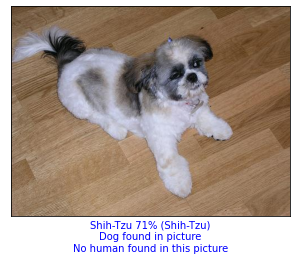

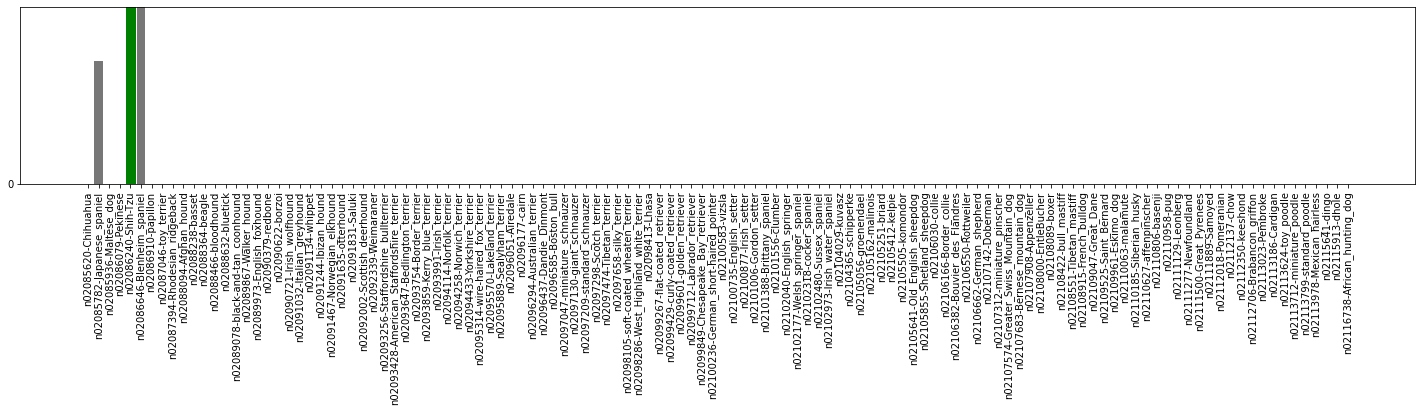

In [35]:
predict_breed(150, data_type='valid')


In [6]:
def predict_breed(img):
 
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    display_img(cv_rgb)
    
    dog_d = 'No dog found in picture'
    human_d = 'No human found in this picture'
    
    if dog_detector(cv_rgb):
        dog_d = 'Dog found in picture'
            
        single_pred = model.predict(img_to_tensor_trained_images(cv_rgb, 150, 150), 
                                    use_multiprocessing=True)
        single_pred_label = np.argmax(single_pred)
        predicted_label = format_race(class_names[1][single_pred_label])
        
        plt.xlabel("{} {:2.0f}% \n{}\n{}".format(predicted_label, 100*np.max(single_pred), dog_d, human_d))
        
        newplot = plt.figure(figsize=(25, 15))
        newplot = plt.subplot(5, 1, 2)
        _ = plot_value_array(single_pred[0], true_race_index)
        _ = plt.xticks(range(120), race_dirs, rotation=90)
        
        if face_detector(gray):
            human_d = 'Human found in this picture'
        
    elif face_detector(gray):
        human_d = 'Human found in this picture'

## Evaluation du model

In [27]:
loss, acc = model.evaluate(X ,y,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

NameError: name 'X' is not defined

In [ ]:
def plot_value_array(predictions_array, true_label):
    #true_label =  true_label[i]
    #true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(120))
    plt.yticks([])
    thisplot = plt.bar(x=range(120), height=predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    #thisplot[true_label].set_color('green')

plt.figure(figsize=(25, 15))
plt.subplot(3, 1, 1)
plot_value_array(single_pred[0], race_dirs_indexed)
_ = plt.xticks(range(120), race_dirs, rotation=90)

In [ ]:
train_mat = loadmat('./train_data.mat')
test_mat = loadmat('./test_data.mat')
print(train_mat.keys())
print(test_mat.keys())

In [ ]:
train_mat_train_info = pd.DataFrame(train_mat.get('train_info'))
test_mat_train_info = pd.DataFrame(train_mat.get('test_fg_data'))

In [ ]:
train_mat_train_info

In [ ]:
test_mat_train_info

In [ ]:
for i in train_mat_train_info.columns:
    column = np.array(train_mat_train_info[i].values.tolist())
    train_mat_train_info[i] = column
    
for i in test_mat_train_info.columns:
    column = np.array(test_mat_train_info[i].values.tolist())
    test_mat_train_info[i] = column

In [ ]:
print(train_mat_train_info.columns)
print(test_mat_train_info.columns)

In [ ]:
labels_distinct = train_mat_train_info.drop_duplicates(['labels'])
class_names = []
for i in labels_distinct:
    dog_race = re.match(r'^\w+-(.+)\/\w+$', i).group(1)
    class_names.append(dog_race)
    print(dog_race)

In [ ]:
class_names

In [ ]:
train_mat_train_info = train_mat_train_info.drop_duplicates(['labels'])

In [ ]:
def load_img(i):
    img = "./dogs-dataset-images/" + train_mat_train_info.file_list[i]
    img = tf.keras.preprocessing.image.load_img(img, target_size=(50,50))
    return img

def load_label(i):
    label_index = train_mat_train_info.labels[i]
    label_race = class_names[label_index-1]
    
    return "{} [{}]".format(label_race, label_index)

In [ ]:
plt.figure(figsize=(10,10))

for i in range(100, 125):
    plt.subplot(5,5,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_img(i))
    plt.xlabel(load_label(i))
    
plt.show()